![Ironhack logo](https://i.imgur.com/1QgrNNw.png)


# Supervised Learning Project

**by Octavio Garcia**

Proyecto de 'aprendizaje supervisado multiclase'. Los requerimientos del proyecto son los siguientes:

- Problema multiclase (utilización del módulo OneVsRestClassifier de sklearn).

- Análisis previo de los datos (balance entre clases).

- Entrenamiento de 2 modelos de ml.

- Extracción de métricas: Accuracy, Precision, Recall, F1Score, ROC Curve, AUC, Confussion Matrix.

Para responder a los requerimientos se ha realizado un 'pipeline' que incluye:

- **Fase 1:** Elección y análisis inicial del dataset.

- **Fase 2:** Preparación del dataset para evaluación de los modelos elegidos.

- **Fase 3:** Evaluación de los modelos.

- **Fase 4:** Entrenamiento de los modelos elegidos y obtención de métricas.



In [1]:
#Importanción de librerías utilizadas en el desarrollo del proyecto.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

## Fase 1: Elección y análisis inicial del dataset.

Se ha elegido un dataset que incluye las estadísticas de baseball, concretamente las estadísticas de bateo por jugador de toda la historia de la Major League Baseball. Dichas estadísticas son valores numéricos que corresponden al desempeño ofensivo de cada jugador durante una temporada completa, sumando un total de 17 estadísticas de bateo más otros dos valores numéricos (año y stint, el cual es un identificador de si el jugador ha estado en más de un equipo en un año).

Asimismo, el dataset incluye features categóricas que corresponden al identificador del jugador, el equipo en el que juega y la liga a la que pertenece el equipo. El clasificador se aplicará sobre el equipo donde juega el jugador de manera que el modelo sea capaz de predecir en que equipo (o cluster de equipos en función de las métricas de los modelos) ha jugado un jugador en función de sus estadísticas de bateo. 

![Ironhack logo](moneyball.jpg)

In [2]:
#Importanción del dataset.
bat = pd.read_csv('./Batting.csv')#,encoding = "ISO-8859-1")

In [3]:
#Visualización del dataset.
bat.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [4]:
#Tamaño del dataset (105861 registros con 22 columnas)
bat.shape

(105861, 22)

In [5]:
#Tipo de datos del dataset
bat.dtypes

playerID     object
yearID        int64
stint         int64
teamID       object
lgID         object
G             int64
AB            int64
R             int64
H             int64
2B            int64
3B            int64
HR            int64
RBI         float64
SB          float64
CS          float64
BB            int64
SO          float64
IBB         float64
HBP         float64
SH          float64
SF          float64
GIDP        float64
dtype: object

In [6]:
#Valores nulos del dataset con valores altos en métricas que no existian .
bat.isna().sum()

playerID        0
yearID          0
stint           0
teamID          0
lgID          738
G               0
AB              0
R               0
H               0
2B              0
3B              0
HR              0
RBI           756
SB           2368
CS          23541
BB              0
SO           2100
IBB         36651
HBP          2817
SH           6069
SF          36104
GIDP        25441
dtype: int64

In [7]:
#Análisis de las variables categóricas. Se crea una función para analizar las variables categóricas.
def selected_feat(selected,df):
    values = []
    leng = selected.shape
    for i in range(leng[0]):
        values.append(df[selected[i]].unique())
        new_df = pd.DataFrame(values).T
    new_df.columns = [i for i in selected]
    return new_df

In [8]:
#Variables categóricas a análizar.
object_col = np.array(['teamID','lgID'])

In [9]:
#Resultado del análisis de las variables categóricas.
selected_feat(object_col,bat).head(10)

,teamID,lgID
0,TRO,NaN
1,RC1,NL
2,CL1,AA
3,WS3,UA
4,FW1,PL
5,BS1,AL
6,PH1,FL
7,CH1,None
8,NY2,None
9,MID,None


Se confirma que es posible eliminar todos los valores nulos ya que corresponden a registros antiguos que no se tendrán en cuenta en el proyecto.

## Fase 2: Preparación del dataset para evaluación de los modelos elegidos.

Se realiza la limpieza y modificación del dataframe para así generar los dataframes X e y para realizar la evaluación de los modelos. Esta es una fase recursiva ya que de una primera valoración de los modelos es posible que se tenga que volver a esta fase para realizar modificaciones en el dataframe de partida en caso de que no se obtengan valores de 'accuracy' suficientes. De hecho, ha sido necesario crear bins en las clases ya que si se tenían en cuenta todos los equipos se obtenian resultados muy pobres para entrenar los modelos (i.e.: Accuracy < 1%).

In [10]:
#Eliminación de los registros con valores nulos.
bat.dropna(inplace=True)

In [11]:
#Verificación de que no existen registros con valores nulos.
bat.isna().sum()

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
G           0
AB          0
R           0
H           0
2B          0
3B          0
HR          0
RBI         0
SB          0
CS          0
BB          0
SO          0
IBB         0
HBP         0
SH          0
SF          0
GIDP        0
dtype: int64

In [12]:
#Se analizan nuevamente las columnas categóricas.
selected_feat(object_col,bat).head(10)

,teamID,lgID
0,BRO,NL
1,SLN,AL
2,PIT,None
3,CHN,None
4,PHI,None
5,BSN,None
6,CIN,None
7,NY1,None
8,CLE,None
9,BOS,None


In [13]:
#Se verifica cuan balancedos están los datos por equipos.
bat.teamID.value_counts()

CLE    2777
CHN    2741
NYA    2719
SLN    2710
CHA    2683
PIT    2682
BOS    2677
PHI    2675
CIN    2644
DET    2637
BAL    2635
LAN    2505
NYN    2446
SFN    2442
HOU    2321
MIN    2274
ATL    2218
OAK    2204
SDN    2166
KCA    2111
TEX    2089
SEA    1839
TOR    1807
MON    1479
CAL    1315
COL    1208
ML4    1060
ARI     974
TBA     964
MIL     947
FLO     849
LAA     832
WAS     670
KC1     572
WS2     430
ML1     408
MIA     341
ANA     337
WS1     290
BRO     161
NY1     156
SE1      53
SLA      49
BSN      44
PHA      40
Name: teamID, dtype: int64

### FILTRADO DE DATOS:

El dataset incluye estadísticas de toda la historia de la MLB, sin embargo, existen muchos equipos en los albores de la historia de la MLB que fueron desapareciendo y equipos que han cambiado de ciudad y/o propietario pero que realmente son los mismos (i.e.: cambio de franquicia). También, han habido cambios importantes en las reglas del juego por lo que he decidido trabajar solamente con los registros posteriores a 1975, año en el que se realizaron las últimas modificaciones importantes al juego. Este filtro también elimina muchos equipos con bajo número de registros.

In [14]:
#Eliminación de registros anteriores a 1975.
bat_1975 = bat[bat.yearID >= 1975]

In [15]:
#Reasignación de nombres de las columnas juntando las franquicias bajo un mismo nombre de equipo.
TEAMS = {'TEX':'Texas Rangers','NYA':'New York Yankees','CLE':'Cleveland Indians','NYN':'New York Mets',
         'SDN':'San Diego Padres','OAK':'Oakland Athletics','BOS':'Boston Red Sox','PIT':'Pittsburgh Pirates',
         'LAN':'Los Angeles Dodgers','KCA':'Kansas City Royals','BAL':'Baltimore Orioles',
         'PHI':'Philadelphia Phillies','CIN':'Cincinnati Reds','ATL':'Atlanta Braves','CHN':'Chicago Cubs',
         'SFN':'San Francisco Giants','SEA':'Seattle Mariners','DET':'Detroit Tigers','CHA':'Chicago White Sox',
         'SLN':'St. Louis Cardinals','TOR':'Toronto Blue Jays','HOU':'Houston Astros','MIN':'Minnesota Twins',
         'MON':'Montreal Expos','COL':'Colorado Rockies','ARI':'Arizona Diamondbacks','TBA':'Tampa Bay Rays',
         'MIL':'Milwaukee Brewers','CAL':'Los Angeles Angels','ML4':'Milwaukee Brewers','FLO':'Miami Marlins',
         'WAS':'Washington Nationals','LAA':'Los Angeles Angels','MIA':'Miami Marlins','ANA':'Los Angeles Angels'}
bat_1975.replace({'teamID':TEAMS},inplace=True)
#Ahora el total de equipos es el total de equipos actuales más los Expos de Montreal que desaparecieron en 2004.
bat_1975['teamID'].unique()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


array(['Milwaukee Brewers', 'Oakland Athletics', 'Philadelphia Phillies',
       'San Francisco Giants', 'Minnesota Twins', 'Baltimore Orioles',
       'Chicago White Sox', 'Los Angeles Angels', 'San Diego Padres',
       'New York Yankees', 'New York Mets', 'Los Angeles Dodgers',
       'Cleveland Indians', 'Boston Red Sox', 'Houston Astros',
       'Cincinnati Reds', 'Detroit Tigers', 'Texas Rangers',
       'Montreal Expos', 'Atlanta Braves', 'St. Louis Cardinals',
       'Kansas City Royals', 'Chicago Cubs', 'Pittsburgh Pirates',
       'Seattle Mariners', 'Toronto Blue Jays', 'Colorado Rockies',
       'Miami Marlins', 'Arizona Diamondbacks', 'Tampa Bay Rays',
       'Washington Nationals'], dtype=object)

In [16]:
#Se verifica de nuevo cuan balanceadas están las clases.
bat_1975.teamID.value_counts()

Texas Rangers            1971
New York Yankees         1963
Cleveland Indians        1937
New York Mets            1933
San Diego Padres         1931
Oakland Athletics        1925
Boston Red Sox           1912
Pittsburgh Pirates       1905
Los Angeles Dodgers      1905
Los Angeles Angels       1902
Kansas City Royals       1892
Philadelphia Phillies    1887
Baltimore Orioles        1887
Cincinnati Reds          1869
Atlanta Braves           1869
Chicago Cubs             1868
San Francisco Giants     1846
Seattle Mariners         1839
Detroit Tigers           1839
Chicago White Sox        1831
St. Louis Cardinals      1824
Milwaukee Brewers        1813
Toronto Blue Jays        1807
Houston Astros           1796
Minnesota Twins          1771
Montreal Expos           1252
Colorado Rockies         1208
Miami Marlins            1190
Arizona Diamondbacks      974
Tampa Bay Rays            964
Washington Nationals      670
Name: teamID, dtype: int64

In [17]:
#También se eliminan aquellos registros que corresponden a jugadores que no batean (i.e.: AT = 0)
bat_AB = bat_1975[bat_1975.AB != 0]#.reset_index()

### BINS:

Tras un primer ciclo de análisis de los modelos, se ha determinado que el problema de 31 clases aporta resultados muy pobres por lo que se decide hacer bins. Para ello se utiliza un nuevo dataset donde se incluyen los campeones (ganadores de la World Series) de cada año desde el año 1975.

In [18]:
#Se crea e importa dataset con ganadores de la World Series desde 1975.
champs = pd.read_csv('./Champions.csv')

In [19]:
#Se agrupan los equipos por número de campeonatos obtenidos desde 1975.
ws_df = pd.DataFrame(champs.CHAMPION.value_counts().reset_index())
ws_df.rename(columns={'index':'Team','CHAMPION':'WorldSeriesTotal'},inplace=True)
ws_df

,Team,WorldSeriesTotal
0,New York Yankees,7
1,Boston Red Sox,4
2,St. Louis Cardinals,3
3,Cincinnati Reds,3
4,San Francisco Giants,3
5,Minnesota Twins,2
6,Kansas City Royals,2
7,Toronto Blue Jays,2
8,Los Angeles Dodgers,2
9,Florida Marlins,2


In [20]:
#Se crea función para generar bins.
def WorldSeries(team):
    equipo = str(team)
    if ws_df['Team'].str.contains(equipo).any() == True:
        if (ws_df.loc[ws_df['Team'] == equipo, 'WorldSeriesTotal'].iloc[0]) > 3:
            team = 'G1 World Series Team'
        elif 2 <= (ws_df.loc[ws_df['Team'] == equipo, 'WorldSeriesTotal'].iloc[0]) <= 3:
            team = 'G2 World Series Team'
        elif (ws_df.loc[ws_df['Team'] == equipo, 'WorldSeriesTotal'].iloc[0]) == 1:
            team = 'G3 World Series Team'
        return team
    else:
        team = "No World Series Team"
        return team

#Se establecen 4 bins: 1)Equipos sin WS, 2)Equipos con más de 3 WS, 3)Equipos con 2-3 WS y 4)Equipos con 1 WS.

In [21]:
#Se crea columna con los bins.
bat_AB['WorldSeries'] = bat_AB['teamID'].apply(WorldSeries)
#NOTA: esta operación dura minutos y no se por que.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
#Se verifica cuan balanceados están las clases. Las clases están bien balanceadas.
bat_AB.WorldSeries.value_counts(sort=False)

No World Series Team    10690
G3 World Series Team    14564
G1 World Series Team     2367
G2 World Series Team    11570
Name: WorldSeries, dtype: int64

In [23]:
#Se eliminan columnas que no serán utilizadas para el entrenamiento.
bat_df = bat_AB.drop(['playerID','lgID','teamID'],axis=1)

In [24]:
#Se modifican las etiquetas de las features para mayor comodidad en el análisis.
STATS = {'G':'Games','AB':'At Bat','R':'Runs Scored','H':'Hits','2B':'Double','3B':'Triple',
         'HR':'Home Runs','RBI':'Run Batted In','SB':'Stolen Base','CS':'Caught Stealing',
         'BB':'Base on Balls','SO':'Strike Out','IBB':'Intentional Base on Balls','HBP':'Hit By Pitch',
         'SH':'Sacrifice Hit','SF':'Sacrifice Fly','GIDP':'Double Plays Induced'}
bat_df.rename(columns=STATS,inplace=True)

In [25]:
#Análisis del dataframe antes del entrenamiento.
display(bat_df.head(),bat_df.shape,bat_df.dtypes)

,yearID,stint,Games,At Bat,Runs Scored,Hits,Double,Triple,Home Runs,Run Batted In,Stolen Base,Caught Stealing,Base on Balls,Strike Out,Intentional Base on Balls,Hit By Pitch,Sacrifice Hit,Sacrifice Fly,Double Plays Induced,WorldSeries
52681,1975,1,137,465,45,109,16,2,12,60.0,0.0,1.0,70,51.0,3.0,1.0,1.0,6.0,15.0,No World Series Team
52684,1975,1,61,90,10,27,2,1,4,15.0,1.0,0.0,11,25.0,0.0,1.0,0.0,1.0,1.0,G2 World Series Team
52685,1975,1,33,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,G2 World Series Team
52687,1975,1,3,3,1,0,0,0,0,0.0,0.0,0.0,1,2.0,0.0,0.0,0.0,0.0,0.0,G2 World Series Team
52688,1975,1,63,10,16,1,0,0,0,0.0,17.0,10.0,1,1.0,0.0,0.0,0.0,0.0,0.0,G3 World Series Team


(39191, 20)

yearID                         int64
stint                          int64
Games                          int64
At Bat                         int64
Runs Scored                    int64
Hits                           int64
Double                         int64
Triple                         int64
Home Runs                      int64
Run Batted In                float64
Stolen Base                  float64
Caught Stealing              float64
Base on Balls                  int64
Strike Out                   float64
Intentional Base on Balls    float64
Hit By Pitch                 float64
Sacrifice Hit                float64
Sacrifice Fly                float64
Double Plays Induced         float64
WorldSeries                   object
dtype: object

In [36]:
#Creación del dataframe de features.
X_columns = [col for col in bat_df.columns.values if col != 'WorldSeries']
X = bat_df[X_columns]
display(X.shape,X.head(),X.columns)

(39191, 19)

,yearID,stint,Games,At Bat,Runs Scored,Hits,Double,Triple,Home Runs,Run Batted In,Stolen Base,Caught Stealing,Base on Balls,Strike Out,Intentional Base on Balls,Hit By Pitch,Sacrifice Hit,Sacrifice Fly,Double Plays Induced
52681,1975,1,137,465,45,109,16,2,12,60.0,0.0,1.0,70,51.0,3.0,1.0,1.0,6.0,15.0
52684,1975,1,61,90,10,27,2,1,4,15.0,1.0,0.0,11,25.0,0.0,1.0,0.0,1.0,1.0
52685,1975,1,33,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
52687,1975,1,3,3,1,0,0,0,0,0.0,0.0,0.0,1,2.0,0.0,0.0,0.0,0.0,0.0
52688,1975,1,63,10,16,1,0,0,0,0.0,17.0,10.0,1,1.0,0.0,0.0,0.0,0.0,0.0


Index(['yearID', 'stint', 'Games', 'At Bat', 'Runs Scored', 'Hits', 'Double',
       'Triple', 'Home Runs', 'Run Batted In', 'Stolen Base',
       'Caught Stealing', 'Base on Balls', 'Strike Out',
       'Intentional Base on Balls', 'Hit By Pitch', 'Sacrifice Hit',
       'Sacrifice Fly', 'Double Plays Induced'],
      dtype='object')

In [37]:
#Creación del dataframe de clases.
y = pd.get_dummies(data=bat_df['WorldSeries'])
display(y.shape,y.head())

(39191, 4)

,G1 World Series Team,G2 World Series Team,G3 World Series Team,No World Series Team
52681,0,0,0,1
52684,0,1,0,0
52685,0,1,0,0
52687,0,1,0,0
52688,0,0,1,0


## Fase 3: Evaluación de los modelos.

En esta fase se realiza la evaluación de los modelos. Para ello se ha hecho primero una correlación entre las features para seleccionar aquellas que sean más discriminantes. Posteriormente se han valorado todos los modelos para así elegir los 2 modelos que mejor resultado ofrezacan a priori.

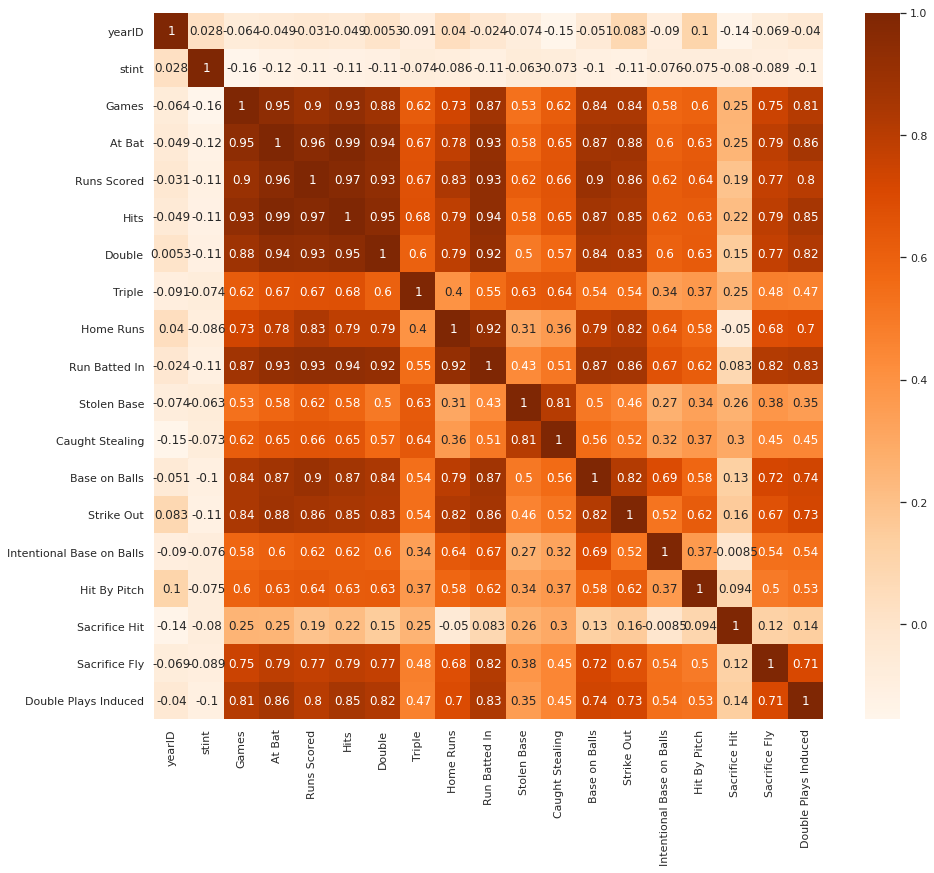

In [38]:
#Primera matriz de correlación.
corr = X.corr()
figure = (15, 13)
fig, ax = pyplot.subplots(figsize=figure)
sns.set()
ax = sns.heatmap(corr,annot=True,cmap="Oranges")

In [39]:
#Eliminación de features no discriminantes (>0.9)
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]

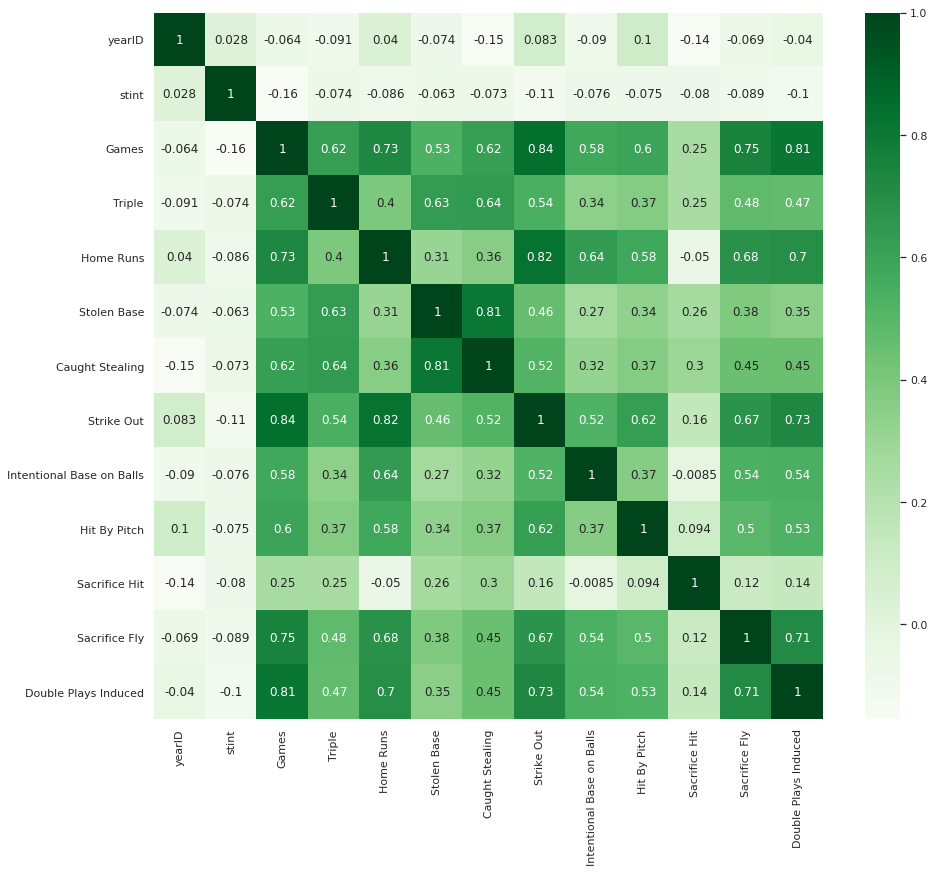

In [40]:
#Segunda matriz de correlación.
corr2 = X.corr()
figure = (15, 13)
fig, ax = pyplot.subplots(figsize=figure)
sns.set()
ax = sns.heatmap(corr2,annot=True,cmap="Greens")

In [41]:
#Se eliminan nuevas columnas a partir del análisis visual de la segunda matriz de correlación.
X = X.drop(['yearID','stint','Games','Strike Out','Double Plays Induced','Home Runs'],axis=1)

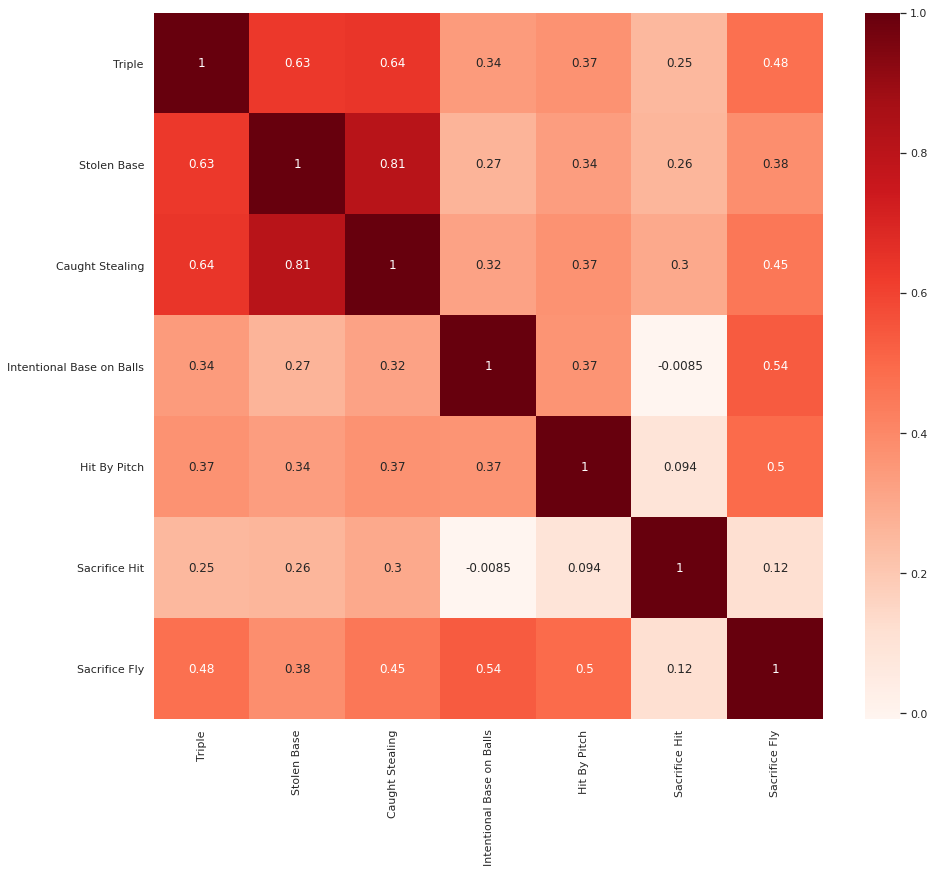

In [42]:
#Tercera matriz de correlación.
corr3 = X.corr()
figure = (15, 13)
fig, ax = pyplot.subplots(figsize=figure)
sns.set()
ax = sns.heatmap(corr3,annot=True,cmap="Reds")

In [43]:
#Logistic Regression multilabel model function with crossvalidation
def LRs(X,y,ns):
    cls = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
    scores = cross_val_score(cls,X,y,cv=ns)
    return print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [44]:
#Evaluación del modelo de regresión logística.
LRs(X,y,5)

Accuracy: 0.0001 (+/- 0.0002)


In [45]:
#Support Vector Machines multilabel model function with crossvalidation
def SVMs(X,y,ns):
    cls = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, class_weight='balanced'))
    scores = cross_val_score(cls,X,y,cv=ns)
    return print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [ ]:
#Evaluación del modelo de regresión logística (NO FUNCIONA)
SVMs(X,y,5)

In [46]:
#Random Forest multilabel model function with crossvalidation
def RFs(X,y,n,ns):
    cls = OneVsRestClassifier(RandomForestClassifier(n_estimators=n))
    scores = cross_val_score(cls,X,y,cv=ns)
    return print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [47]:
#Evaluación del modelo Random Forest (n_estimators = 20).
RFs(X,y,20,5)

Accuracy: 0.0741 (+/- 0.0150)


In [48]:
#K Neighbors multilabel model function with crossvalidation
def KNNs(X,y,k,ns):
    cls = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(cls,X,y,cv=ns)
    return print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [49]:
#Evaluación del modelo Random Forest (n_neighbors = 10).
KNNs(X,y,10,5)

Accuracy: 0.0598 (+/- 0.0213)


## Fase 4: Entrenamiento de los modelos elegidos y obtención de métricas.

En esta fase se realiza el entrenamiento de los modelos elegidos en función de los resultados obtenidos en la fase anterior. La fase anterior arrojó el siguiente resultado para cada uno de los modelos analizados:

- **Regresión Logística:** Ha arrojado un valor de accuracy muy bajo por lo que se descarta su utilización.

- **Support Vector Machines:** No ha sido posible probar este modelo.

- **Random Forest:** Ha arrojado un accuracy de ''. Es uno de los dos modelos elegidos.

- **K Neighbors:** Ha arrojado un accuracy de ''. Es uno de los dos modelos elegidos.

Las métricas que deberán aportarse para cada modelo son las siguientes: **Precision, Recall, F1Score, ROC Curve, AUC, Confussion Matrix.**

### Modelo 1 - Random Forest

**n_estimators = 20**

In [60]:
#Se crean los dataframe de entrenamiento y de prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35271, 7)

(3920, 7)

(35271, 4)

(3920, 4)

#### Precision, recall, F1Score

In [62]:
cls_RandomForestClassifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
cls_RandomForestClassifier.fit(X_train,y_train)
y_pred = cls_RandomForestClassifier.predict(X_test)

In [63]:
act_val_rf = y_test.values.argmax(axis=1)
pred_rf = cls_RandomForestClassifier.predict(X_test).argmax(axis=1)

In [68]:
def metrics_df(actual_values,predictions):
    precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
    recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
    f1_s = pd.DataFrame(f1_score(actual_values, predictions,average=None))
    metrics = pd.concat([precision, recall, f1_s], axis=1)
    metrics.index = ['No World Series Team','G1 World Series Team','G2 World Series Team','G3 World Series Team']
    metrics.columns = ['precision', 'recall', 'f1_score']
    metrics.columns.name = 'WorldSeries'
    return metrics

In [69]:
metrics_df(act_val_rf,pred_rf)

WorldSeries,precision,recall,f1_score
No World Series Team,0.062171,0.825328,0.115632
G1 World Series Team,0.342723,0.064204,0.108148
G2 World Series Team,0.368098,0.127841,0.189773
G3 World Series Team,0.387640,0.060209,0.104230


#### ROC Curve, AUC

In [70]:
def roc_curve_multiclass(n_classes,X_train,X_test,y_train,y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Agregación de los falsos positivos
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #Interpolación de las ROC Curve en este punto
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Computo del AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #ROC curves
    plt.figure()
    fig, ax = plt.subplots(figsize=(15,15))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

<Figure size 432x288 with 0 Axes>

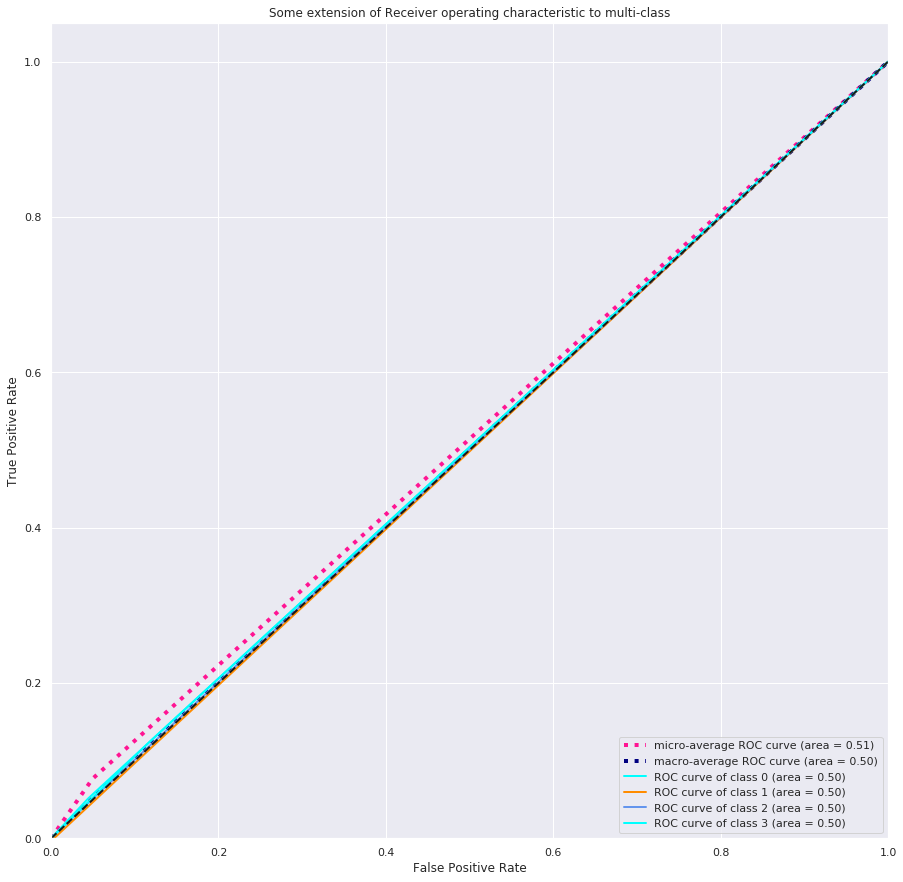

In [71]:
y_binarize = label_binarize(y, classes=['No World Series Team','G1 World Series Team',
                                  'G2 World Series Team','G3 World Series Team'])
n_classes = y.shape[1]

# Compute macro-average ROC curve and ROC area
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y_binarize, test_size=0.20,random_state=13)

cls_ = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))
cls_.fit(X_train_,y_train_)
y_score = cls_.predict(X_test_)

roc_curve_multiclass(n_classes,X_train_, X_test_, y_train_, y_test_, y_score)

#### Confussion Matrix

In [72]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
Index(['G1 World Series Team', 'G2 World Series Team', 'G3 World Series Team',
       'No World Series Team'],
      dtype='object')


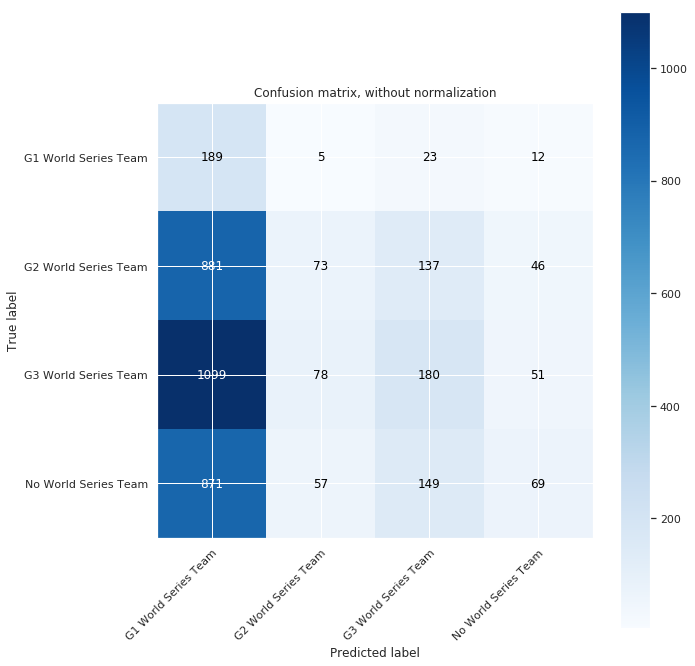

In [79]:
plot_confusion_matrix(act_val_rf,pred_rf,y.columns,cmap='Blues')

### Modelo 2 - K Neighbors

**n_neighbors = 10**

In [74]:
#Se crean los dataframe de entrenamiento y de prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35271, 7)

(3920, 7)

(35271, 4)

(3920, 4)

#### Precision, recall, F1Score

In [75]:
cls_KNNClassifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10))
cls_KNNClassifier.fit(X_train,y_train)
y_pred = cls_KNNClassifier.predict(X_test)

In [76]:
act_val_knn = y_test.values.argmax(axis=1)
pred_knn = cls_KNNClassifier.predict(X_test).argmax(axis=1)

In [77]:
metrics_df(act_val_knn,pred_knn)

WorldSeries,precision,recall,f1_score
No World Series Team,0.063730,0.890830,0.118950
G1 World Series Team,0.329114,0.091469,0.143152
G2 World Series Team,0.404834,0.095170,0.154112
G3 World Series Team,0.375000,0.023560,0.044335


#### ROC Curve, AUC

<Figure size 432x288 with 0 Axes>

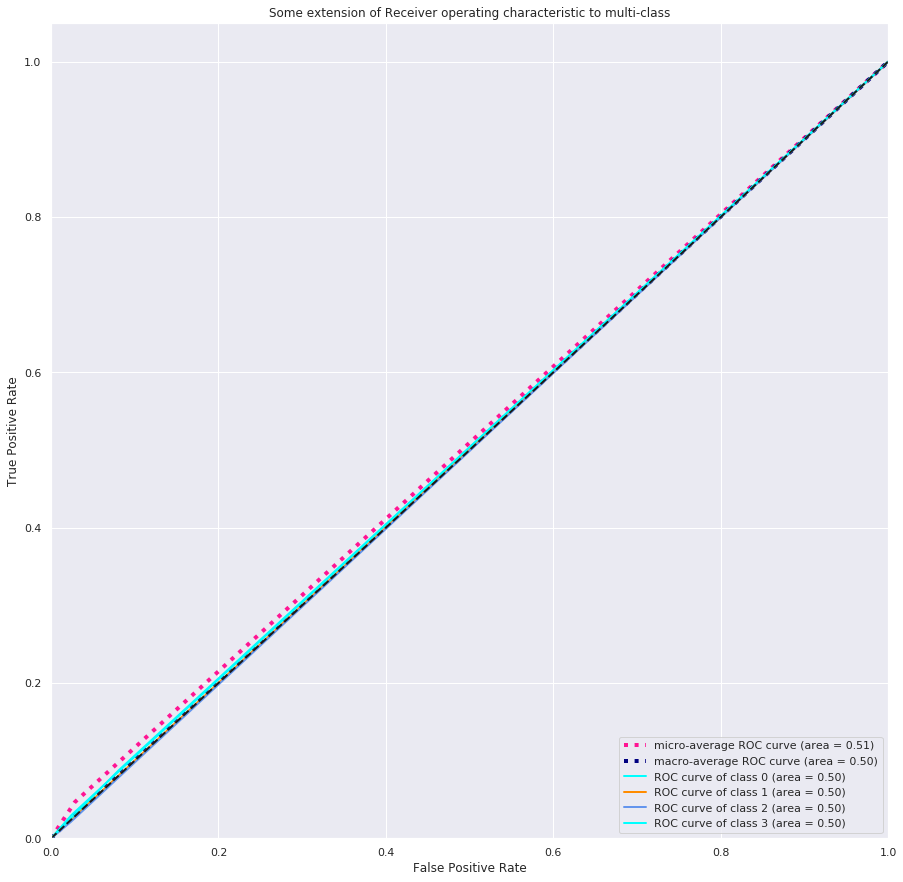

In [78]:
y_binarize = label_binarize(y, classes=['No World Series Team','G1 World Series Team',
                                  'G2 World Series Team','G3 World Series Team'])
n_classes = y.shape[1]

# Compute macro-average ROC curve and ROC area
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y_binarize, test_size=0.20,random_state=13)

cls_ = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10))
cls_.fit(X_train_,y_train_)
y_score = cls_.predict(X_test_)

roc_curve_multiclass(n_classes,X_train_, X_test_, y_train_, y_test_, y_score)

#### Confussion Matrix

Confusion matrix, without normalization


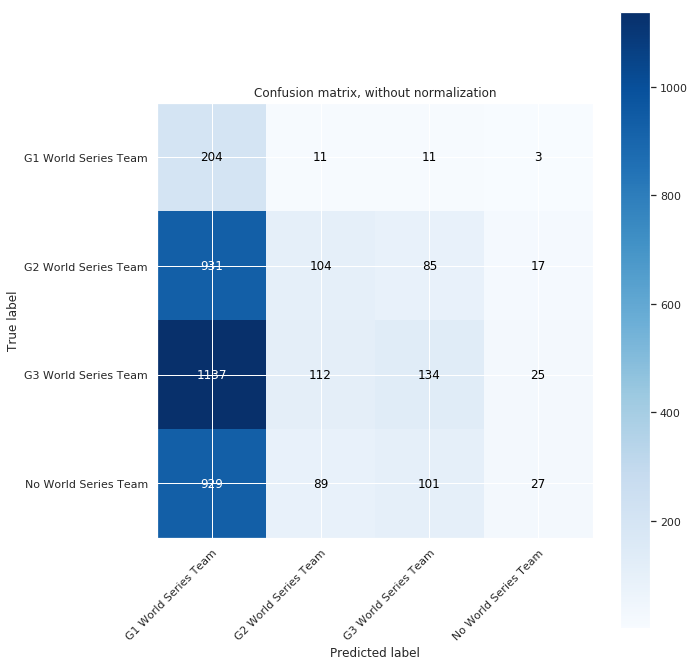

In [80]:
plot_confusion_matrix(act_val_knn,pred_knn,y.columns,cmap='Blues')

## Conclusiones

Si bien los resultados no son satisfactoriosen cuanto a las métricas obtenidas, si se considera que son coherentes ya que en todos los equipos existen jugadores con buenas estadísticas y con malas estadísticas por lo que las estadísticas de bateo no son del todo discriminatorias. 

Para mejorar los resultados del enfoque planteado se propone realizar nuevas iteraciones jugando con el conjunto de datos para identificar 'clusters' dentro del conjunto de jugadores (e.g.: eliminar registros de jugadores con ciertas estadísticas que los marquen como irrelevantes para el estudio o afinar incluso más la selección de features. 

También, se podría probar con más detalle la performance de los diferentes modelos utilizando un menor número de bins.